# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/yairrios/Documents/KTH/Second Year/Scalable_ML/mlfs-book_YairRT_SofieSchn
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:

# parameters
country = "united-kingdom"
city = "scotland"
street = "edinburgh-salamander-st"
model_number = "1"
sensor_secret_name = f"SENSOR_LOCATION_JSON_{street.replace(' ', '_')}"

In [4]:
# Parameters
model_number = 5
street = "edinburgh-st-leonards"


In [5]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 22, 27, 40, 116781)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [6]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
#location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
#location = json.loads(location_str)
#country=location['country']
#city=location['city']
#street=location['street']

2025-11-17 22:27:40,126 INFO: Initializing external client


2025-11-17 22:27:40,126 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 22:27:40,694 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 22:27:41,571 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272002


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name=f"air_quality_xgboost_model_{model_number}",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()
print(saved_model_dir)


2025-11-17 22:27:45,820 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/526471 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/492783 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/459257 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/514194 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/508265 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114245 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112002 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/101987 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110958 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113027 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28329 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28002 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28590 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27755 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28400 elapsed<00:00 remaining<?

/var/folders/8j/7633yjhn4k36wll68zkkbvsr0000gn/T/7ba9326f-9a17-47f7-8c28-c6d01883463e/air_quality_xgboost_model_5/1


In [8]:
# List all versions for a specific model
models = mr.get_models(name="air_quality_xgboost_model_5")
for model in models:
    print(f"Model name: {model.name}, version: {model.version}")

Model name: air_quality_xgboost_model_5, version: 1


In [9]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + f"/model_{model_number}.json")

#/Users/yairrios/Documents/KTH/Second Year/Scalable_ML/mlfs-book_YairRT_SofieSchn/air_quality_model/model_1.json
# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model
print("Model expects these features:")
print(retrieved_xgboost_model.get_booster().feature_names)

Model expects these features:
['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [10]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,-1.50,0.0,21.674870,327.893768,scotland
1,2025-11-22 00:00:00+00:00,1.65,0.0,6.877790,96.008919,scotland
2,2025-11-21 00:00:00+00:00,0.10,0.1,2.811690,140.194473,scotland
3,2025-11-18 00:00:00+00:00,-0.20,0.5,5.815978,68.198532,scotland
4,2025-11-23 00:00:00+00:00,1.05,0.0,1.835647,78.690102,scotland
5,2025-11-20 00:00:00+00:00,0.50,0.0,15.990646,328.815094,scotland


In [11]:
# Compute lag features for each prediction date (Grade C requirement)
# The model expects lag features, so we need to compute them from historical PM2.5 data

# Get the air quality feature group to read historical PM2.5 values
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)

# Ensure dates are in datetime format for proper comparison
batch_data['date'] = pd.to_datetime(batch_data['date'])

# Read all historical PM2.5 data for this street (we need enough history for lag features)
historical_pm25 = (
    air_quality_fg.read()
    .query("street == @street")
    .sort_values('date')
    [['date', 'pm25']]
)
historical_pm25['date'] = pd.to_datetime(historical_pm25['date'])

# Initialize lag feature columns
batch_data['pm25_lag_1'] = 0.0
batch_data['pm25_lag_2'] = 0.0
batch_data['pm25_lag_3'] = 0.0
batch_data['pm25_roll_3'] = 0.0

# For each prediction date, compute lag features from historical data
for idx, pred_date in enumerate(batch_data['date']):
    lag_1_date = pred_date - datetime.timedelta(days=1)
    lag_2_date = pred_date - datetime.timedelta(days=2)
    lag_3_date = pred_date - datetime.timedelta(days=3)
    
    # Look up PM2.5 values from historical data
    lag_1_val = historical_pm25[historical_pm25['date'] == lag_1_date]['pm25'].values
    lag_2_val = historical_pm25[historical_pm25['date'] == lag_2_date]['pm25'].values
    lag_3_val = historical_pm25[historical_pm25['date'] == lag_3_date]['pm25'].values
    
    # Set lag values (use 0.0 if historical data not available)
    batch_data.at[batch_data.index[idx], 'pm25_lag_1'] = lag_1_val[0] if len(lag_1_val) > 0 else 0.0
    batch_data.at[batch_data.index[idx], 'pm25_lag_2'] = lag_2_val[0] if len(lag_2_val) > 0 else 0.0
    batch_data.at[batch_data.index[idx], 'pm25_lag_3'] = lag_3_val[0] if len(lag_3_val) > 0 else 0.0
    
    # Compute rolling 3-day mean from the lag values
    lag_values = [
        batch_data.at[batch_data.index[idx], 'pm25_lag_1'],
        batch_data.at[batch_data.index[idx], 'pm25_lag_2'],
        batch_data.at[batch_data.index[idx], 'pm25_lag_3']
    ]
    non_zero_values = [v for v in lag_values if v != 0.0]
    if len(non_zero_values) > 0:
        batch_data.at[batch_data.index[idx], 'pm25_roll_3'] = sum(non_zero_values) / len(non_zero_values)
    else:
        batch_data.at[batch_data.index[idx], 'pm25_roll_3'] = 0.0

print("Lag features computed for batch_data:")
print(batch_data[['date', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3']].head())
batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.55s) 
Lag features computed for batch_data:
                       date  pm25_lag_1  pm25_lag_2  pm25_lag_3  pm25_roll_3
0 2025-11-19 00:00:00+00:00         0.0        18.0        23.0         20.5
1 2025-11-22 00:00:00+00:00         0.0         0.0         0.0          0.0
2 2025-11-21 00:00:00+00:00         0.0         0.0         0.0          0.0
3 2025-11-18 00:00:00+00:00        18.0        23.0         0.0         20.5
4 2025-11-23 00:00:00+00:00         0.0         0.0         0.0          0.0


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3
0,2025-11-19 00:00:00+00:00,-1.50,0.0,21.674870,327.893768,scotland,0.0,18.0,23.0,20.5
1,2025-11-22 00:00:00+00:00,1.65,0.0,6.877790,96.008919,scotland,0.0,0.0,0.0,0.0
2,2025-11-21 00:00:00+00:00,0.10,0.1,2.811690,140.194473,scotland,0.0,0.0,0.0,0.0
3,2025-11-18 00:00:00+00:00,-0.20,0.5,5.815978,68.198532,scotland,18.0,23.0,0.0,20.5
4,2025-11-23 00:00:00+00:00,1.05,0.0,1.835647,78.690102,scotland,0.0,0.0,0.0,0.0
5,2025-11-20 00:00:00+00:00,0.50,0.0,15.990646,328.815094,scotland,0.0,0.0,18.0,18.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [12]:
# old --> batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    #old --> batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

# added features for the new features (c level)
# Include lag features in prediction (model expects lag features first, then weather features - Grade C requirement)
feature_cols = [
    'pm25_lag_1',
    'pm25_lag_2',
    'pm25_lag_3',
    'pm25_roll_3',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant'
]

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[feature_cols])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3,predicted_pm25
0,2025-11-19 00:00:00+00:00,-1.50,0.0,21.674870,327.893768,scotland,0.0,18.0,23.0,20.5,27.793175
1,2025-11-22 00:00:00+00:00,1.65,0.0,6.877790,96.008919,scotland,0.0,0.0,0.0,0.0,10.259865
2,2025-11-21 00:00:00+00:00,0.10,0.1,2.811690,140.194473,scotland,0.0,0.0,0.0,0.0,9.187294
3,2025-11-18 00:00:00+00:00,-0.20,0.5,5.815978,68.198532,scotland,18.0,23.0,0.0,20.5,19.283272
4,2025-11-23 00:00:00+00:00,1.05,0.0,1.835647,78.690102,scotland,0.0,0.0,0.0,0.0,9.539380
5,2025-11-20 00:00:00+00:00,0.50,0.0,15.990646,328.815094,scotland,0.0,0.0,18.0,18.0,27.128843


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1                   6 non-null      float64                
 7   pm25_lag_2                   6 non-null      float64                
 8   pm25_lag_3                   6 non-null      float64                
 9   pm25_roll_3                  6 non-null      float64                
 10  predic

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [14]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3,predicted_pm25,street,country,days_before_forecast_day
3,2025-11-18 00:00:00+00:00,-0.20,0.5,5.815978,68.198532,scotland,18.0,23.0,0.0,20.5,19.283272,edinburgh-st-leonards,united-kingdom,4
0,2025-11-19 00:00:00+00:00,-1.50,0.0,21.674870,327.893768,scotland,0.0,18.0,23.0,20.5,27.793175,edinburgh-st-leonards,united-kingdom,1
5,2025-11-20 00:00:00+00:00,0.50,0.0,15.990646,328.815094,scotland,0.0,0.0,18.0,18.0,27.128843,edinburgh-st-leonards,united-kingdom,6
2,2025-11-21 00:00:00+00:00,0.10,0.1,2.811690,140.194473,scotland,0.0,0.0,0.0,0.0,9.187294,edinburgh-st-leonards,united-kingdom,3
1,2025-11-22 00:00:00+00:00,1.65,0.0,6.877790,96.008919,scotland,0.0,0.0,0.0,0.0,10.259865,edinburgh-st-leonards,united-kingdom,2
4,2025-11-23 00:00:00+00:00,1.05,0.0,1.835647,78.690102,scotland,0.0,0.0,0.0,0.0,9.539380,edinburgh-st-leonards,united-kingdom,5


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 3 to 4
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1                   6 non-null      float64                
 7   pm25_lag_2                   6 non-null      float64                
 8   pm25_lag_3                   6 non-null      float64                
 9   pm25_roll_3                  6 non-null      float64                
 10  predicted_p

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-17 22:28:02,164 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



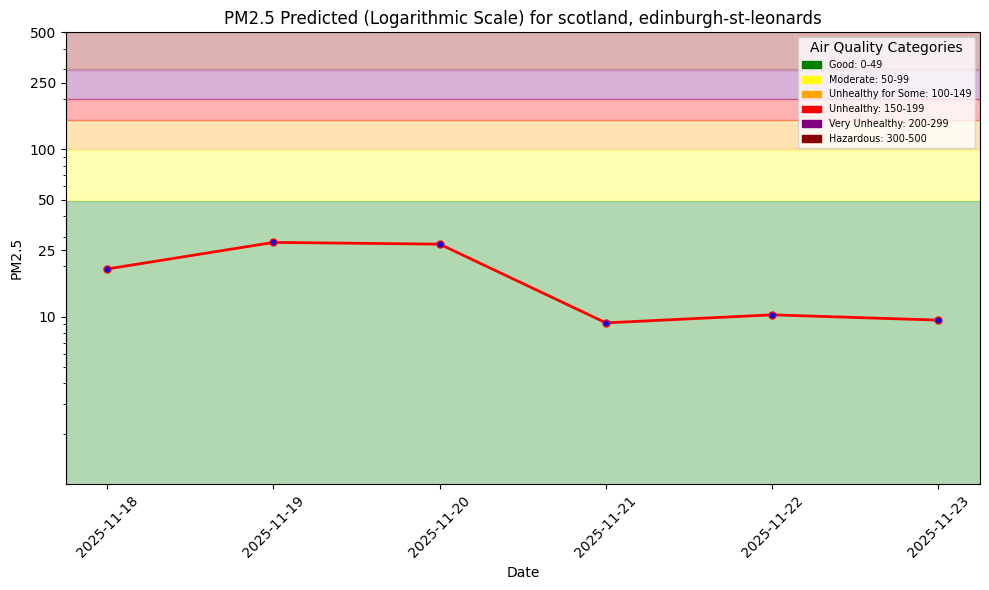

In [16]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{model_number}.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [17]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name=f'aq_predictions_{model_number}',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [18]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272002/fs/1265755/fg/1730966


Uploading Dataframe: 0.00% |          | Rows 0/6 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 16.67% |█▋        | Rows 1/6 | Elapsed Time: 00:01 | Remaining Time: 00:05

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: aq_predictions_5_2_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272002/jobs/named/aq_predictions_5_2_offline_fg_materialization/executions


2025-11-17 22:28:21,084 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED


2025-11-17 22:28:24,267 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


2025-11-17 22:30:50,752 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED


2025-11-17 22:30:50,926 INFO: Waiting for log aggregation to finish.


2025-11-17 22:30:59,503 INFO: Execution finished successfully.


(Job('aq_predictions_5_2_offline_fg_materialization', 'SPARK'), None)

In [19]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-1.5,0.0,21.67487,327.893768,scotland,0.0,18.0,23.0,20.5,27.793175,edinburgh-st-leonards,united-kingdom,1


In [20]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


,date,pm25,country,city,street,url,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3
0,2014-11-26 00:00:00+00:00,64.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,57.0,36.0,21.0,38.000000
1,2020-08-31 00:00:00+00:00,82.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,54.0,51.0,83.0,62.666667
2,2020-02-24 00:00:00+00:00,36.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,28.0,51.0,49.0,42.666667
3,2021-03-06 00:00:00+00:00,12.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,30.0,34.0,39.0,34.333333
4,2021-03-12 00:00:00+00:00,26.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,14.0,12.0,16.0,14.000000
...,...,...,...,...,...,...,...,...,...,...
18824,2024-09-30 00:00:00+00:00,30.0,united-kingdom,scotland,edinburgh-st-leonards,https://api.waqi.info/feed/@3176,11.0,10.0,9.0,17.000000
18825,2024-03-19 00:00:00+00:00,19.0,united-kingdom,scotland,edinburgh-st-leonards,https://api.waqi.info/feed/@3176,13.0,11.0,12.0,14.333333
18826,2017-12-23 00:00:00+00:00,12.0,united-kingdom,scotland,edinburgh-st-leonards,https://api.waqi.info/feed/@3176,31.0,43.0,16.0,28.666667
18827,2023-08-22 00:00:00+00:00,8.0,united-kingdom,scotland,edinburgh-st-leonards,https://api.waqi.info/feed/@3176,16.0,17.0,12.0,13.666667


In [21]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


Uploading Dataframe: 0.00% |          | Rows 0/12 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 8.33% |▊         | Rows 1/12 | Elapsed Time: 00:01 | Remaining Time: 00:12

Uploading Dataframe: 100.00% |██████████| Rows 12/12 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: aq_predictions_5_2_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272002/jobs/named/aq_predictions_5_2_offline_fg_materialization/executions


2025-11-17 22:31:22,529 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED


2025-11-17 22:31:25,715 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


2025-11-17 22:33:04,337 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED


2025-11-17 22:33:04,497 INFO: Waiting for log aggregation to finish.


2025-11-17 22:33:16,536 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-16 00:00:00+00:00,-0.354667,0.0,17.081041,326.538269,scotland,0.0,0.0,0.0,0.0,10.444265,20.0,edinburgh-salamander-st,united-kingdomfa,1
1,2025-11-16 00:00:00+00:00,-0.354667,0.0,17.081041,326.538269,scotland,0.0,0.0,0.0,0.0,10.444265,18.0,edinburgh-salamander-st,united-kingdom,1
2,2025-11-16 00:00:00+00:00,-0.354667,0.0,17.081041,326.538269,scotland,0.0,0.0,0.0,0.0,10.444265,20.0,edinburgh-queensferry-road,united-kingdom,1
3,2025-11-16 00:00:00+00:00,-0.354667,0.0,17.081041,326.538269,scotland,0.0,0.0,0.0,0.0,10.444265,21.0,east-lothian-musselburgh-n-high-st,united-kingdom,1
4,2025-11-16 00:00:00+00:00,-0.354667,0.0,17.081041,326.538269,scotland,0.0,0.0,0.0,0.0,10.444265,39.0,west-lothian-broxburn,united-kingdom,1
5,2025-11-16 00:00:00+00:00,-0.354667,0.0,17.081041,326.538269,scotland,0.0,0.0,0.0,0.0,10.444265,23.0,edinburgh-st-leonards,united-kingdom,1
6,2025-11-17 00:00:00+00:00,2.100000,0.0,12.031756,308.927551,scotland,23.0,0.0,0.0,23.0,26.459341,30.0,edinburgh-salamander-st,united-kingdom,1
7,2025-11-17 00:00:00+00:00,2.100000,0.0,12.031756,308.927551,scotland,23.0,0.0,0.0,23.0,26.459341,22.0,edinburgh-queensferry-road,united-kingdom,1
8,2025-11-17 00:00:00+00:00,2.100000,0.0,12.031756,308.927551,scotland,23.0,0.0,0.0,23.0,26.459341,21.0,east-lothian-musselburgh-n-high-st,united-kingdom,1
9,2025-11-17 00:00:00+00:00,2.100000,0.0,12.031756,308.927551,scotland,23.0,0.0,0.0,23.0,26.459341,27.0,west-lothian-broxburn,united-kingdom,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

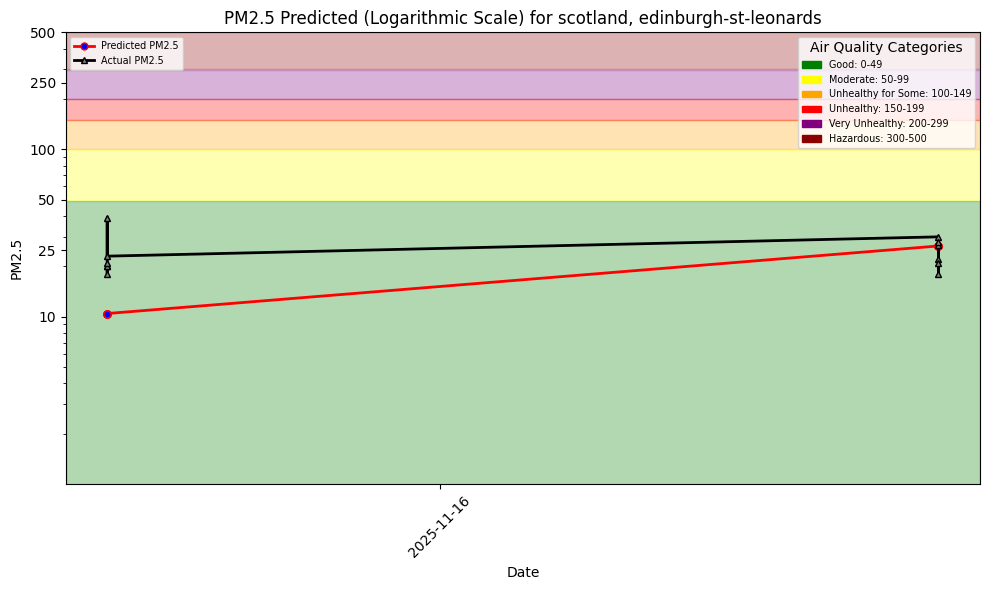

In [22]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{model_number}.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [23]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/yairrios/Documents/KTH/Second Year/Scalable_ML/mlfs-book_YairRT_SofieSchn/docs/air-quality/as…

Uploading /Users/yairrios/Documents/KTH/Second Year/Scalable_ML/mlfs-book_YairRT_SofieSchn/docs/air-quality/as…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272002/settings/fb/path/Resources/airquality


---